# SPX Top 50 Basket Realized Volatility Analysis
## Market Cap Weighted Portfolio Volatility vs SPX Index Comparison
### Calculate and visualize the realized volatility of a market cap weighted basket of the top 50 SPX components over the last 10 years.

#### Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("📊 SPX TOP 50 BASKET VOLATILITY ANALYSIS")
print("=" * 60)
print("Market cap weighted portfolio volatility calculation")

📊 SPX TOP 50 BASKET VOLATILITY ANALYSIS
Market cap weighted portfolio volatility calculation


#### Load Data

In [4]:
# Load the 10-year volatility data
vol_data_path = '../data/historical_volatility/ten_year_volatility_latest.csv'
vol_df = pd.read_csv(vol_data_path)
vol_df['date'] = pd.to_datetime(vol_df['date'])

# Load SPX weights (if available)
weights_path = '../data/processed/spx_weights/spx_weights_latest.csv'

try:
    weights_df = pd.read_csv(weights_path)
    print("✅ Loaded SPX market cap weights")
    
    # Get top 50 components with weights
    top_50_weights = weights_df.head(50).copy()
    
    # Normalize weights to sum to 100%
    total_weight = top_50_weights['market_cap_weight_pct'].sum()
    top_50_weights['normalized_weight'] = (top_50_weights['market_cap_weight_pct'] / total_weight) * 100
    
    print(f"   Top 50 components weight coverage: {total_weight:.1f}% of SPX")
    print(f"   Normalized to: {top_50_weights['normalized_weight'].sum():.1f}%")
    
except FileNotFoundError:
    print("⚠️ SPX weights file not found, using equal weights for top 50")
    
    # Get top 50 tickers from volatility data (excluding SPX Index)
    component_tickers = vol_df[vol_df['ticker'] != 'SPX Index']['ticker'].unique()
    top_50_tickers = component_tickers[:50]  # Take first 50
    
    # Create equal weights DataFrame
    top_50_weights = pd.DataFrame({
        'ticker': top_50_tickers,
        'normalized_weight': [100/50] * 50  # Equal 2% weights
    })
    
    print(f"   Using equal weights: {100/50:.1f}% per component")

print(f"\nTop 10 Holdings:")
for i, row in top_50_weights.head(50).iterrows():
    ticker_clean = row['ticker'].replace(' US Equity', '')
    print(f"   {i+1:2d}. {ticker_clean:8s} {row['normalized_weight']:5.2f}%")

✅ Loaded SPX market cap weights
   Top 50 components weight coverage: 75.1% of SPX
   Normalized to: 100.0%

Top 10 Holdings:
    1. NVDA     18.45%
    2. AAPL     13.83%
    3. AMZN     10.53%
    4. META      7.76%
    5. AVGO      5.84%
    6. V         3.03%
    7. NFLX      2.25%
    8. MA        2.20%
    9. XOM       2.04%
   10. PG        1.59%
   11. HD        1.57%
   12. ABBV      1.47%
   13. GE        1.23%
   14. CSCO      1.18%
   15. UNH       1.12%
   16. CRM       1.10%
   17. GS        0.99%
   18. DIS       0.96%
   19. ABT       0.94%
   20. AXP       0.94%
   21. MCD       0.93%
   22. INTU      0.92%
   23. NOW       0.87%
   24. TXN       0.86%
   25. PEP       0.86%
   26. CAT       0.85%
   27. T         0.85%
   28. UBER      0.83%
   29. ISRG      0.82%
   30. ACN       0.78%
   31. C         0.77%
   32. BA        0.76%
   33. SPGI      0.72%
   34. NEE       0.69%
   35. ADBE      0.68%
   36. HON       0.67%
   37. SYK       0.65%
   38. ETN       0.65%


#### Data Preparation

In [5]:
# Filter volatility data for our basket components and SPX Index
basket_tickers = top_50_weights['ticker'].tolist()
analysis_tickers = basket_tickers + ['SPX Index']

# Filter data
basket_data = vol_df[vol_df['ticker'].isin(analysis_tickers)].copy()

print(f"📊 DATA PREPARATION")
print(f"   Basket components: {len(basket_tickers)}")
print(f"   Available tickers in data: {len(basket_data['ticker'].unique())}")
print(f"   Date range: {basket_data['date'].min().strftime('%Y-%m-%d')} to {basket_data['date'].max().strftime('%Y-%m-%d')}")

# Check data availability for each component
print(f"\nData coverage check:")
missing_tickers = []
for ticker in basket_tickers:
    ticker_data = basket_data[basket_data['ticker'] == ticker]
    if len(ticker_data) == 0:
        missing_tickers.append(ticker)
    else:
        realized_data = ticker_data[ticker_data['data_type'] == 'realized']
        print(f"   {ticker}: {len(realized_data):,} realized vol observations")

if missing_tickers:
    print(f"\n⚠️ Missing data for {len(missing_tickers)} tickers:")
    for ticker in missing_tickers[:10]:  # Show first 10
        print(f"   - {ticker}")
    
    # Remove missing tickers from weights and renormalize
    top_50_weights = top_50_weights[~top_50_weights['ticker'].isin(missing_tickers)]
    total_remaining_weight = top_50_weights['normalized_weight'].sum()
    top_50_weights['normalized_weight'] = (top_50_weights['normalized_weight'] / total_remaining_weight) * 100
    
    print(f"   Adjusted basket to {len(top_50_weights)} components")
    print(f"   Renormalized weights sum: {top_50_weights['normalized_weight'].sum():.1f}%")

📊 DATA PREPARATION
   Basket components: 50
   Available tickers in data: 51
   Date range: 2015-07-20 to 2025-07-18

Data coverage check:
   NVDA US Equity: 2,515 realized vol observations
   AAPL US Equity: 2,515 realized vol observations
   AMZN US Equity: 2,515 realized vol observations
   META US Equity: 2,515 realized vol observations
   AVGO US Equity: 2,515 realized vol observations
   V US Equity: 2,515 realized vol observations
   NFLX US Equity: 2,515 realized vol observations
   MA US Equity: 2,515 realized vol observations
   XOM US Equity: 2,515 realized vol observations
   PG US Equity: 2,515 realized vol observations
   HD US Equity: 2,515 realized vol observations
   ABBV US Equity: 2,515 realized vol observations
   GE US Equity: 2,515 realized vol observations
   CSCO US Equity: 2,515 realized vol observations
   UNH US Equity: 2,515 realized vol observations
   CRM US Equity: 2,515 realized vol observations
   GS US Equity: 2,515 realized vol observations
   DIS US 

#### Calculate Basket Realized Volatility

In [6]:
def calculate_basket_realized_volatility(vol_data, weights_df, vol_field='realized_vol_252d'):
    """
    Calculate market cap weighted basket realized volatility
    """
    print(f"📈 CALCULATING BASKET VOLATILITY ({vol_field})")
    print("=" * 50)
    
    # Get realized volatility data
    realized_data = vol_data[vol_data['data_type'] == 'realized'].copy()
    
    # Create weights lookup
    weights_lookup = weights_df.set_index('ticker')['normalized_weight'].to_dict()
    
    # Filter for components with both data and weights
    valid_tickers = []
    for ticker in weights_df['ticker']:
        ticker_data = realized_data[realized_data['ticker'] == ticker]
        if len(ticker_data) > 0 and ticker_data[vol_field].notna().sum() > 100:  # At least 100 observations
            valid_tickers.append(ticker)
    
    print(f"Valid components with data: {len(valid_tickers)}")
    
    # Calculate daily basket volatility
    all_dates = sorted(realized_data['date'].unique())
    basket_volatility = []
    
    for date in all_dates:
        date_data = realized_data[realized_data['date'] == date]
        
        # Get volatility for valid components on this date
        date_vol_data = {}
        total_weight_available = 0
        
        for ticker in valid_tickers:
            ticker_row = date_data[date_data['ticker'] == ticker]
            if len(ticker_row) > 0 and ticker_row[vol_field].notna().iloc[0]:
                vol_value = ticker_row[vol_field].iloc[0]
                weight = weights_lookup[ticker]
                date_vol_data[ticker] = {'vol': vol_value, 'weight': weight}
                total_weight_available += weight
        
        # Calculate weighted average if we have sufficient coverage
        if total_weight_available > 50:  # At least 50% weight coverage
            weighted_vol = 0
            for ticker, data in date_vol_data.items():
                # Normalize weight to available coverage
                normalized_weight = (data['weight'] / total_weight_available)
                weighted_vol += data['vol'] * normalized_weight
            
            basket_volatility.append({
                'date': date,
                'basket_realized_vol': weighted_vol,
                'weight_coverage': total_weight_available,
                'components_count': len(date_vol_data)
            })
    
    basket_vol_df = pd.DataFrame(basket_volatility)
    print(f"Calculated basket volatility for {len(basket_vol_df):,} dates")
    print(f"Average weight coverage: {basket_vol_df['weight_coverage'].mean():.1f}%")
    print(f"Average components per date: {basket_vol_df['components_count'].mean():.1f}")
    
    return basket_vol_df

# Calculate basket volatility for 252-day (annual) realized vol
basket_vol_252d = calculate_basket_realized_volatility(basket_data, top_50_weights, 'realized_vol_252d')

# Also calculate for 90-day realized vol for comparison
basket_vol_90d = calculate_basket_realized_volatility(basket_data, top_50_weights, 'realized_vol_90d')

📈 CALCULATING BASKET VOLATILITY (realized_vol_252d)
Valid components with data: 50
Calculated basket volatility for 2,515 dates
Average weight coverage: 99.4%
Average components per date: 49.1
📈 CALCULATING BASKET VOLATILITY (realized_vol_90d)
Valid components with data: 50
Calculated basket volatility for 2,515 dates
Average weight coverage: 99.5%
Average components per date: 49.2


#### Get SPX Index Volatility for Comparison

In [7]:
# Get SPX Index realized volatility
spx_realized = basket_data[
    (basket_data['ticker'] == 'SPX Index') & 
    (basket_data['data_type'] == 'realized')
].copy()

print(f"📊 SPX INDEX COMPARISON DATA")
print(f"   SPX realized vol observations: {len(spx_realized):,}")
print(f"   252D vol availability: {spx_realized['realized_vol_252d'].notna().sum():,}")
print(f"   90D vol availability: {spx_realized['realized_vol_90d'].notna().sum():,}")

# Merge basket and SPX data
comparison_252d = pd.merge(
    basket_vol_252d[['date', 'basket_realized_vol', 'weight_coverage']], 
    spx_realized[['date', 'realized_vol_252d']].rename(columns={'realized_vol_252d': 'spx_realized_vol'}),
    on='date', 
    how='inner'
)

comparison_90d = pd.merge(
    basket_vol_90d[['date', 'basket_realized_vol', 'weight_coverage']], 
    spx_realized[['date', 'realized_vol_90d']].rename(columns={'realized_vol_90d': 'spx_realized_vol'}),
    on='date', 
    how='inner'
)

print(f"\nComparison datasets created:")
print(f"   252D comparison: {len(comparison_252d):,} overlapping dates")
print(f"   90D comparison: {len(comparison_90d):,} overlapping dates")

📊 SPX INDEX COMPARISON DATA
   SPX realized vol observations: 2,515
   252D vol availability: 2,515
   90D vol availability: 2,515

Comparison datasets created:
   252D comparison: 2,515 overlapping dates
   90D comparison: 2,515 overlapping dates


#### Visualization: 10-Year Basket vs SPX Volatility

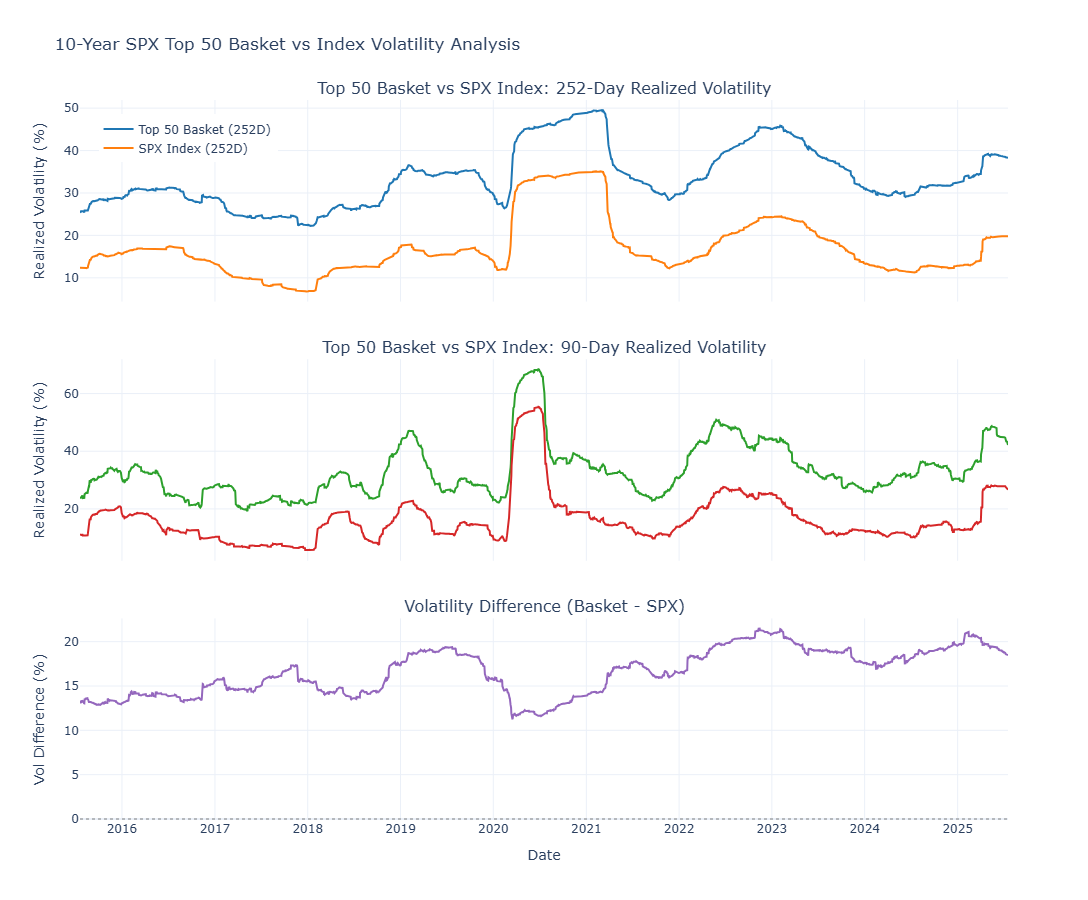

In [8]:
# Create comprehensive comparison chart
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=[
        'Top 50 Basket vs SPX Index: 252-Day Realized Volatility',
        'Top 50 Basket vs SPX Index: 90-Day Realized Volatility', 
        'Volatility Difference (Basket - SPX)'
    ],
    vertical_spacing=0.08,
    shared_xaxes=True
)

# Plot 1: 252-day comparison
if len(comparison_252d) > 0:
    fig.add_trace(
        go.Scatter(
            x=comparison_252d['date'],
            y=comparison_252d['basket_realized_vol'],
            mode='lines',
            name='Top 50 Basket (252D)',
            line=dict(color='#1f77b4', width=2),
            hovertemplate='<b>Top 50 Basket</b><br>Date: %{x}<br>252D Vol: %{y:.2f}%<extra></extra>'
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=comparison_252d['date'],
            y=comparison_252d['spx_realized_vol'],
            mode='lines',
            name='SPX Index (252D)',
            line=dict(color='#ff7f0e', width=2),
            hovertemplate='<b>SPX Index</b><br>Date: %{x}<br>252D Vol: %{y:.2f}%<extra></extra>'
        ),
        row=1, col=1
    )

# Plot 2: 90-day comparison
if len(comparison_90d) > 0:
    fig.add_trace(
        go.Scatter(
            x=comparison_90d['date'],
            y=comparison_90d['basket_realized_vol'],
            mode='lines',
            name='Top 50 Basket (90D)',
            line=dict(color='#2ca02c', width=2),
            hovertemplate='<b>Top 50 Basket</b><br>Date: %{x}<br>90D Vol: %{y:.2f}%<extra></extra>',
            showlegend=False
        ),
        row=2, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=comparison_90d['date'],
            y=comparison_90d['spx_realized_vol'],
            mode='lines',
            name='SPX Index (90D)',
            line=dict(color='#d62728', width=2),
            hovertemplate='<b>SPX Index</b><br>Date: %{x}<br>90D Vol: %{y:.2f}%<extra></extra>',
            showlegend=False
        ),
        row=2, col=1
    )

# Plot 3: Volatility difference
if len(comparison_252d) > 0:
    vol_diff = comparison_252d['basket_realized_vol'] - comparison_252d['spx_realized_vol']
    
    fig.add_trace(
        go.Scatter(
            x=comparison_252d['date'],
            y=vol_diff,
            mode='lines',
            name='Vol Difference (252D)',
            line=dict(color='#9467bd', width=2),
            hovertemplate='<b>Volatility Difference</b><br>Date: %{x}<br>Difference: %{y:.2f}%<extra></extra>',
            showlegend=False
        ),
        row=3, col=1
    )
    
    # Add zero line
    fig.add_hline(y=0, line_dash="dot", line_color="gray", opacity=0.5, row=3, col=1)

# Update layout
fig.update_layout(
    title='10-Year SPX Top 50 Basket vs Index Volatility Analysis',
    height=900,
    template='plotly_white',
    showlegend=True,
    legend=dict(x=0.02, y=0.98)
)

# Update y-axis labels
fig.update_yaxes(title_text="Realized Volatility (%)", row=1, col=1)
fig.update_yaxes(title_text="Realized Volatility (%)", row=2, col=1)
fig.update_yaxes(title_text="Vol Difference (%)", row=3, col=1)
fig.update_xaxes(title_text="Date", row=3, col=1)

fig.show()

#### Statistical Analysis

In [9]:
print(f"\n📊 STATISTICAL ANALYSIS: BASKET vs SPX VOLATILITY")
print("=" * 70)

if len(comparison_252d) > 0:
    # 252-day analysis
    basket_252 = comparison_252d['basket_realized_vol']
    spx_252 = comparison_252d['spx_realized_vol']
    diff_252 = basket_252 - spx_252
    
    print(f"252-DAY REALIZED VOLATILITY COMPARISON:")
    print(f"   Observation period: {comparison_252d['date'].min().strftime('%Y-%m-%d')} to {comparison_252d['date'].max().strftime('%Y-%m-%d')}")
    print(f"   Total observations: {len(comparison_252d):,}")
    print(f"")
    print(f"   TOP 50 BASKET STATISTICS:")
    print(f"     Average: {basket_252.mean():.2f}%")
    print(f"     Median:  {basket_252.median():.2f}%")
    print(f"     Min:     {basket_252.min():.2f}%")
    print(f"     Max:     {basket_252.max():.2f}%")
    print(f"     Std Dev: {basket_252.std():.2f}%")
    print(f"")
    print(f"   SPX INDEX STATISTICS:")
    print(f"     Average: {spx_252.mean():.2f}%")
    print(f"     Median:  {spx_252.median():.2f}%")
    print(f"     Min:     {spx_252.min():.2f}%")
    print(f"     Max:     {spx_252.max():.2f}%")
    print(f"     Std Dev: {spx_252.std():.2f}%")
    print(f"")
    print(f"   DIFFERENCE ANALYSIS (Basket - SPX):")
    print(f"     Average difference: {diff_252.mean():.2f}%")
    print(f"     Median difference:  {diff_252.median():.2f}%")
    print(f"     Std dev of diff:    {diff_252.std():.2f}%")
    print(f"     Basket higher:      {(diff_252 > 0).mean()*100:.1f}% of time")
    print(f"     Max overestimate:   {diff_252.max():.2f}%")
    print(f"     Max underestimate:  {diff_252.min():.2f}%")
    
    # Correlation
    correlation = basket_252.corr(spx_252)
    print(f"     Correlation:        {correlation:.3f}")

if len(comparison_90d) > 0:
    print(f"\n90-DAY REALIZED VOLATILITY COMPARISON:")
    basket_90 = comparison_90d['basket_realized_vol']
    spx_90 = comparison_90d['spx_realized_vol']
    diff_90 = basket_90 - spx_90
    
    print(f"   Average difference: {diff_90.mean():.2f}%")
    print(f"   Correlation:        {basket_90.corr(spx_90):.3f}")
    print(f"   Basket higher:      {(diff_90 > 0).mean()*100:.1f}% of time")


📊 STATISTICAL ANALYSIS: BASKET vs SPX VOLATILITY
252-DAY REALIZED VOLATILITY COMPARISON:
   Observation period: 2015-07-20 to 2025-07-18
   Total observations: 2,515

   TOP 50 BASKET STATISTICS:
     Average: 33.60%
     Median:  31.84%
     Min:     22.19%
     Max:     49.55%
     Std Dev: 6.93%

   SPX INDEX STATISTICS:
     Average: 17.01%
     Median:  15.29%
     Min:     6.77%
     Max:     35.19%
     Std Dev: 6.85%

   DIFFERENCE ANALYSIS (Basket - SPX):
     Average difference: 16.59%
     Median difference:  16.75%
     Std dev of diff:    2.59%
     Basket higher:      100.0% of time
     Max overestimate:   21.49%
     Max underestimate:  11.25%
     Correlation:        0.930

90-DAY REALIZED VOLATILITY COMPARISON:
   Average difference: 16.79%
   Correlation:        0.937
   Basket higher:      100.0% of time


#### Regime Analysis


🎭 VOLATILITY REGIME ANALYSIS
Volatility by Market Regime (252-day):
               basket_realized_vol             spx_realized_vol        \
                              mean   std count             mean   std   
spx_vol_regime                                                          
Low Vol                      28.22  3.10  1118            11.93  2.12   
Normal Vol                   35.89  4.79  1136            18.18  2.88   
Elevated Vol                 46.43  2.19   241            33.56  1.65   
High Vol                     49.42  0.09    20            35.09  0.06   

               vol_difference        
                         mean   std  
spx_vol_regime                       
Low Vol                 16.30  1.99  
Normal Vol              17.71  2.52  
Elevated Vol            12.86  1.05  
High Vol                14.34  0.05  


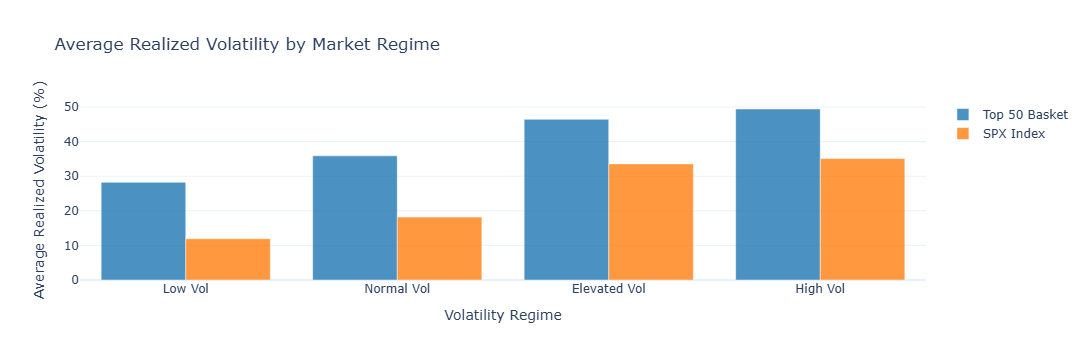

In [10]:
# Analyze volatility differences by market regime
if len(comparison_252d) > 0:
    print(f"\n🎭 VOLATILITY REGIME ANALYSIS")
    print("=" * 50)
    
    # Define volatility regimes based on SPX volatility
    comparison_252d['spx_vol_regime'] = pd.cut(
        comparison_252d['spx_realized_vol'],
        bins=[0, 15, 25, 35, float('inf')],
        labels=['Low Vol', 'Normal Vol', 'Elevated Vol', 'High Vol']
    )
    
    comparison_252d['vol_difference'] = comparison_252d['basket_realized_vol'] - comparison_252d['spx_realized_vol']
    
    # Calculate regime statistics
    regime_stats = comparison_252d.groupby('spx_vol_regime').agg({
        'basket_realized_vol': ['mean', 'std', 'count'],
        'spx_realized_vol': ['mean', 'std'],
        'vol_difference': ['mean', 'std']
    }).round(2)
    
    print("Volatility by Market Regime (252-day):")
    print(regime_stats)
    
    # Create regime comparison chart
    regime_summary = comparison_252d.groupby('spx_vol_regime').agg({
        'basket_realized_vol': 'mean',
        'spx_realized_vol': 'mean',
        'vol_difference': 'mean'
    }).reset_index()
    
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
        x=regime_summary['spx_vol_regime'],
        y=regime_summary['basket_realized_vol'],
        name='Top 50 Basket',
        marker_color='#1f77b4',
        opacity=0.8
    ))
    
    fig.add_trace(go.Bar(
        x=regime_summary['spx_vol_regime'],
        y=regime_summary['spx_realized_vol'],
        name='SPX Index',
        marker_color='#ff7f0e',
        opacity=0.8
    ))
    
    fig.update_layout(
        title='Average Realized Volatility by Market Regime',
        xaxis_title='Volatility Regime',
        yaxis_title='Average Realized Volatility (%)',
        barmode='group',
        template='plotly_white'
    )
    
    fig.show()

#### Key Insights Summary

In [11]:
print(f"\n🎯 KEY INSIGHTS: TOP 50 BASKET vs SPX INDEX")
print("=" * 70)

if len(comparison_252d) > 0:
    avg_diff = (comparison_252d['basket_realized_vol'] - comparison_252d['spx_realized_vol']).mean()
    correlation = comparison_252d['basket_realized_vol'].corr(comparison_252d['spx_realized_vol'])
    basket_higher_pct = ((comparison_252d['basket_realized_vol'] - comparison_252d['spx_realized_vol']) > 0).mean() * 100
    
    print(f"📊 PORTFOLIO CONSTRUCTION INSIGHTS:")
    print(f"   • Market cap weighted top 50 represents ~{top_50_weights['normalized_weight'].sum():.0f}% of SPX")
    print(f"   • Basket tracks SPX volatility with {correlation:.1%} correlation")
    print(f"   • Average volatility difference: {avg_diff:+.2f}%")
    
    if abs(avg_diff) < 0.5:
        assessment = "🟢 EXCELLENT tracking - minimal difference"
    elif abs(avg_diff) < 1.0:
        assessment = "🟡 GOOD tracking - small systematic difference"
    else:
        assessment = "🔴 NOTABLE difference - consider rebalancing"
    
    print(f"   • Tracking assessment: {assessment}")
    
    print(f"\n📈 TRADING & RISK MANAGEMENT IMPLICATIONS:")
    if avg_diff > 0:
        print(f"   • Top 50 basket typically MORE volatile than SPX ({basket_higher_pct:.0f}% of time)")
        print(f"   • Consider: Single-name diversification benefits vs concentration risk")
    else:
        print(f"   • Top 50 basket typically LESS volatile than SPX ({100-basket_higher_pct:.0f}% of time)")
        print(f"   • Consider: Large-cap concentration provides some volatility dampening")
    
    print(f"\n💰 VOLATILITY TRADING STRATEGY IMPLICATIONS:")
    print(f"   • Index options vs basket options pricing differences")
    print(f"   • Cross-volatility arbitrage opportunities")
    print(f"   • Portfolio hedging efficiency analysis")
    
    # Historical extremes
    max_diff = (comparison_252d['basket_realized_vol'] - comparison_252d['spx_realized_vol']).max()
    min_diff = (comparison_252d['basket_realized_vol'] - comparison_252d['spx_realized_vol']).min()
    
    print(f"\n⚡ HISTORICAL EXTREMES:")
    print(f"   • Largest basket premium: +{max_diff:.2f}%")
    print(f"   • Largest basket discount: {min_diff:.2f}%")
    print(f"   • Range of differences: {max_diff - min_diff:.2f}% volatility points")

print(f"\n🎉 ANALYSIS COMPLETE!")
print(f"This basket volatility analysis provides insights for:")
print(f"• Portfolio construction and optimization")
print(f"• Index tracking and replication strategies") 
print(f"• Volatility arbitrage opportunities")
print(f"• Risk management and hedging decisions")


🎯 KEY INSIGHTS: TOP 50 BASKET vs SPX INDEX
📊 PORTFOLIO CONSTRUCTION INSIGHTS:
   • Market cap weighted top 50 represents ~100% of SPX
   • Basket tracks SPX volatility with 93.0% correlation
   • Average volatility difference: +16.59%
   • Tracking assessment: 🔴 NOTABLE difference - consider rebalancing

📈 TRADING & RISK MANAGEMENT IMPLICATIONS:
   • Top 50 basket typically MORE volatile than SPX (100% of time)
   • Consider: Single-name diversification benefits vs concentration risk

💰 VOLATILITY TRADING STRATEGY IMPLICATIONS:
   • Index options vs basket options pricing differences
   • Cross-volatility arbitrage opportunities
   • Portfolio hedging efficiency analysis

⚡ HISTORICAL EXTREMES:
   • Largest basket premium: +21.49%
   • Largest basket discount: 11.25%
   • Range of differences: 10.24% volatility points

🎉 ANALYSIS COMPLETE!
This basket volatility analysis provides insights for:
• Portfolio construction and optimization
• Index tracking and replication strategies
• Vola